In [1]:
import os
import sys
import torch
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb
import yaml
from scipy.fft import rfft

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from lab_scripts.constellation_diagram import RingShapedConstellation, get_constellation, QPSK_Constellation
from modules.models import TCN_channel, TCN, memory_polynomial_channel
from modules.utils import *

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = torch.device("mps") # for M chip Macs
else:
    DEVICE = torch.device("cpu")
print("DEVICE", DEVICE)

c:\Users\maild\miniconda3\envs\mldrivenpeled\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE cuda


In [2]:
TCN_CHANNEL = False


run_name = "comfy-sweep-115"
tcn_channel_model, remote_config = load_runs_final_artifact(run_name, device=DEVICE)
file_name = remote_config['training_data']
file_path = rf"..\data\channel_measurements\zarr_files\{file_name}"
ofdm_info = extract_zarr_data(file_path, DEVICE)


if TCN_CHANNEL:
    channel_model = tcn_channel_model
else:


    sent_frames_time = ofdm_info.sent_frames_time
    received_frames_time = ofdm_info.received_frames_time
    dataset = ChannelData(sent_frames_time, received_frames_time, ofdm_info.FREQUENCIES)

    # Split sizes
    train_size = int(0.9 * len(dataset))
    

    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size  # ensures total = 100%

    # Perform split
    TRAIN_DATASET, VAL_DATASET, TEST_DATASET = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    memory_polynomial = memory_polynomial_channel(weights=None, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2, device=DEVICE)
    train_indices = TRAIN_DATASET.indices
    _, _, _ = memory_polynomial.fit(dataset.sent[train_indices], dataset.received[train_indices])
    
    channel_model = memory_polynomial 
    run_name = f"Trained on MP channel model with memory linear {channel_model.memory_linear} | memory nonlinear {channel_model.memory_nonlinear} | nonlinearity order {channel_model.nonlinearity_order}"


# Freeze before moving to DEVICE
for param in channel_model.parameters():
    param.requires_grad = False


channel_model = channel_model.to(DEVICE).float()
channel_model.eval()

Loading from ../models\channel_models\comfy-sweep-115\channel_model_final.pth


c:\Users\maild\mldrivenpeled\modules\utils.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(local_weights_path, map_location="cpu")
c:\Users\maild\

Loaded from cache!


memory_polynomial_channel()

wandb: Currently logged in as: dylanbackprops (dylanbackprops-university-of-washington) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Channel model parameters frozen: True


WandB run info:
  Name: lyric-rain-412
  ID: jr5irl5j
  URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/runs/jr5irl5j
Chosen hyperparameters for this session:
{'CP_ratio': 0.25, 'batch_size': 16, 'dc_offset': 0, 'num_taps': 10, 'epochs': 750, 'gain': 20, 'lr': 0.001, 'nlayers': 2, 'hidden_channels': 8, 'dilation_base': 2, 'preamble_amplitude': 3, 'num_symbols_per_frame': 1, 'scheduler_type': 'reduce_lr_on_plateu', 'weight_init': 'default', 'training_data': 'channel_3e5-7.6MHz_2.68.V_0.125A_scale2_dynamic_power_0.5-3_v2.zarr', 'DELTA_K': 10000, 'K_MIN': 30, 'K_MAX': 759, 'NF': 730, 'modulator': 'qpsk'}


c:\Users\maild\mldrivenpeled\modules\utils.py:292: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  sent_filtered = F.conv1d(sent_time.unsqueeze(1), h, padding='same').squeeze(1)
C:\Users\maild\AppData\Local\Temp\ipykernel_24472\1062805377.py:232: RuntimeWarning: divide by zero encountered in divide
  snr_vs_freq = (received_power / received_noise_power + 1e-12)
C:\Users\maild\AppData\Local\Temp\ipykernel_24472\1062805377.py:265: RuntimeWarning: divide by zero encountered in log10
  ax.plot(10 * np.log10(received_noise_power[:len(snr_vs_freq)//2]))


KeyboardInterrupt: 

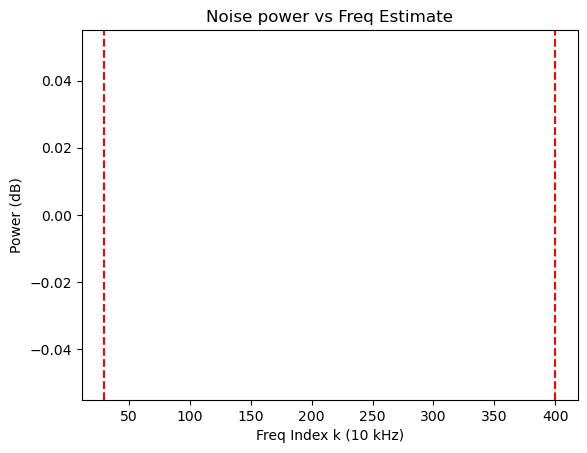

In [ ]:
print("Channel model parameters frozen:",
      all(not param.requires_grad for param in channel_model.parameters()))

constellation_mode = "qpsk"

constellation = get_constellation(constellation_mode)

script_dir = os.getcwd()
config_path = os.path.join(script_dir, "..", "configs/offline_time_ae_config.yml")
with open(config_path, "r") as f:
    hyperparams = yaml.safe_load(f)
    hyperparams['training_data'] = remote_config['training_data']
    hyperparams['DELTA_K'] = remote_config['DELTA_K']                       
    hyperparams['K_MIN'] = remote_config['K_MIN']                          
    hyperparams['K_MAX'] = remote_config['K_MAX']                            
    hyperparams['NF'] = remote_config['Nf']

    wandb.init(project="mldrivenpeled",
            config=hyperparams,
            tags=['autoencoder'])
    config = wandb.config
    if wandb.run.notes is None:
        wandb.run.notes = ""
    config.modulator = constellation_mode
    wandb.run.notes += wandb.run.notes + f"\n | trained on channel model {run_name} \n | {constellation_mode}"
    print("WandB run info:")
    print(f"  Name: {wandb.run.name}")
    print(f"  ID: {wandb.run.id}")
    print(f"  URL: {wandb.run.url}")
    print("Chosen hyperparameters for this session:")
    print(config)

encoder = TCN(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels,
).to(DEVICE)

decoder = TCN(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels
).to(DEVICE)

wandb.config.update({"num_params_encoder": encoder.get_num_params()}, allow_val_change=True)
wandb.config.update({"num_params_decoder": decoder.get_num_params()}, allow_val_change=True)

optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=config.lr, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr=1e-6)


val_ofdm_settings = OFDM_channel()

NUM_BITS = config.NF * constellation.modulation_order

FREQUENCIES = remote_config['DELTA_K'] * torch.arange(remote_config['K_MIN'], remote_config['K_MAX'] + 1)

delta_f = FREQUENCIES[1] - FREQUENCIES[0]
KS = (FREQUENCIES / delta_f).to(torch.int)

K_MIN = int(KS[0].item())
K_MAX = int(KS[-1].item())
NUM_POS_FREQS = K_MAX + 1
RIGHT_PADDING_ZEROS = (ofdm_info.NUM_POINTS_FRAME - 2 *  NUM_POS_FREQS) // 2
LEFT_PADDING_ZEROS = K_MIN - 1
PREAMBLE_MAX = config.preamble_amplitude

val_ofdm_settings = OFDM_channel(
    FREQUENCIES=FREQUENCIES,
    NUM_POINTS_SYMBOL=ofdm_info.NUM_POINTS_SYMBOL,
    CP_LENGTH=ofdm_info.CP_LENGTH,
    DELTA_K=int(delta_f.item()),
    KS=KS,
    K_MIN=K_MIN,
    K_MAX=K_MAX,
    LEFT_PADDING_ZEROS=LEFT_PADDING_ZEROS,
    CP_RATIO=ofdm_info.CP_RATIO,
    NUM_POINTS_FRAME=ofdm_info.NUM_POINTS_FRAME,
    NUM_POS_FREQS=NUM_POS_FREQS,
    RIGHT_PADDING_ZEROS=RIGHT_PADDING_ZEROS
)

def train(channel_model, encoder, decoder, optimizer, scheduler, config, DEVICE, mask=None):

    encoder = encoder.to(DEVICE)
    decoder = decoder.to(DEVICE)

    average_encoded_power = 0.0
    for epoch in range(config["epochs"]):
        encoder.train()
        decoder.train()
        epoch_loss = 0
        epoch_freq_loss = 0
        optimizer.zero_grad()
        batch_entries = []
        true_bits_list = []
        for batch in range(config["batch_size"]):
            # Generate frame data
            true_bits = np.random.randint(0, 2, size=NUM_BITS)
            true_bits_list.append(torch.tensor(true_bits))
            true_bits_str = ''.join(map(str, true_bits))
            true_symbols = torch.tensor(
                constellation.bits_to_symbols(true_bits_str),
                dtype=torch.complex64, device=DEVICE
            )
            true_frame = true_symbols.reshape(1, config["NF"])


            batch_entries.append(true_frame)

        true_bits = torch.stack(true_bits_list)

        # Batch along time domain
        true_frame = torch.cat(batch_entries)

        # print("Inband symbol power", true_frame.abs().square().mean())
        # Convert to time domain
        sent_frames_time = symbols_to_time(true_frame, val_ofdm_settings.LEFT_PADDING_ZEROS, val_ofdm_settings.RIGHT_PADDING_ZEROS)
        sent_frames_time = torch.hstack((sent_frames_time[:, -val_ofdm_settings.CP_LENGTH:], sent_frames_time))

        # print(f"Encoder Ave Pwr In {sent_frames_time.square().mean().item(): .3f}")
        encoded_frames_time = encoder(sent_frames_time)
        average_encoded_power += encoded_frames_time.square().mean().item()

        # print(f"Encoder Ave Pwr Out {encoded_frames_time.square().mean().item(): .3f}")

        # encoded_frames_time = in_band_filter(encoded_frames_time, KS, NUM_POINTS_FRAME)

        # Clip to preamble make
        encoded_frames_time = torch.clip(encoded_frames_time, -PREAMBLE_MAX, PREAMBLE_MAX)

        if TCN_CHANNEL:
            received_frames_time, mean, std, nu = channel_model(encoded_frames_time)
            if torch.isnan(received_frames_time).any():
                raise ValueError("NaN in Loss!")
        else:
            received_frames_time = channel_model(encoded_frames_time)
            mean = received_frames_time
            std = torch.nan
            nu = torch.nan


        decoded_frames_time = decoder(received_frames_time)

        # Convert to frequency domain for loss
        sent_frames_frequency = torch.tensor(rfft(sent_frames_time[:, val_ofdm_settings.CP_LENGTH:].detach().cpu().numpy(), norm='ortho', axis=1)[:, KS])
        decoded_frames_frequency = torch.tensor(rfft(decoded_frames_time[:, val_ofdm_settings.CP_LENGTH:].detach().cpu().numpy(), norm='ortho', axis=1)[:, KS])

        loss = in_band_time_loss(sent_frames_time, decoded_frames_time, ks_indices=KS, n_fft=val_ofdm_settings.NUM_POINTS_FRAME, num_taps=config['num_taps'])


        diff_complex = sent_frames_frequency.detach() - decoded_frames_frequency.detach()
        freq_loss = torch.mean(diff_complex.abs().pow(2))
        loss.backward()
        epoch_loss += loss.item()
        epoch_freq_loss += freq_loss.item()


        optimizer.step()
        scheduler.step(epoch_loss)

        wandb.log({"loss": epoch_loss}, step=epoch)
        wandb.log({"freq_loss": epoch_freq_loss}, step=epoch)
        lr = optimizer.param_groups[0]["lr"]
        wandb.log({"learning_rate": lr}, step=epoch)

        # Get BER
        ber = calculate_BER(decoded_frames_frequency.detach().flatten(), true_bits.flatten(), constellation=constellation)
        wandb.log({"BER": ber}, step=epoch)

        if epoch % 5 == 0:
            make_time_validate_plots(
            sent_frames_time[0],
            encoded_frames_time[0],
            received_frames_time[0],
            decoded_frames_time[0],
            frame_BER=ber,
            run_model=True,
            step=epoch
            )

            # Plot first example of sent and reconstructed time
            fig, ax = plt.subplots()
            ax.plot(sent_frames_time[0][:100].detach().cpu().numpy(), label="Sent (time)")
            ax.plot(decoded_frames_time[0][:100].detach().cpu().numpy(), label="Decoded (time)")
            ax.legend()
            ax.set_title(f"Sent vs Decoded (Time Domain) EVM: {loss: 0.3e}")
            wandb.log({"time_domain_plot": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            sent_symbols = sent_frames_frequency[0].detach().cpu().numpy()
            decoded_symbols = decoded_frames_frequency[0].detach().cpu().numpy()

            # Compute EVM for logging (per frame)
            evm_val = evm_loss(torch.tensor(sent_symbols), torch.tensor(decoded_symbols)).item()

            # Create constellation plot
            fig, ax = plt.subplots()
            ax.scatter(sent_symbols.real, sent_symbols.imag, color='blue', alpha=0.6, label='Sent')
            ax.scatter(decoded_symbols.real, decoded_symbols.imag, color='red', alpha=0.6, label='Decoded')
            ax.set_xlabel('In-phase')
            ax.set_ylabel('Quadrature')
            ax.set_title(f'Constellation Diagram EVM: {evm_val:0.3e}')
            ax.legend()
            ax.grid(True)

            # Log to wandb
            wandb.log({"constellation": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            evm_per_freq = ((sent_frames_frequency[0] - decoded_frames_frequency[0]).abs()**2).detach().cpu().numpy()
            fig, ax = plt.subplots()
            ax.plot(evm_per_freq)
            ax.set_title("EVM vs Frequency")
            wandb.log({"evm_vs_freq": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            if TCN_CHANNEL:
                # Plot Model SNRs
                sent_k = torch.fft.fft(encoded_frames_time[:, val_ofdm_settings.CP_LENGTH:], norm="ortho", dim=-1)
                received_k = torch.fft.fft(mean[:, val_ofdm_settings.CP_LENGTH:], norm="ortho", dim=-1)

                residual = received_frames_time - mean
                received_noise_k = torch.fft.fft(residual[:, val_ofdm_settings.CP_LENGTH:] ** 2, norm="ortho", dim=-1)


                signal_power = torch.mean(torch.abs(sent_k) ** 2, dim=0).detach().cpu().numpy()
                received_power = torch.mean(torch.abs(received_k) ** 2, dim=0).detach().cpu().numpy()
                received_noise_power = torch.mean(torch.abs(received_noise_k), dim=0).detach().cpu().numpy()
                snr_vs_freq = (received_power / received_noise_power + 1e-12)

                fig, ax = plt.subplots()
                ax.plot(10 * np.log10(signal_power[:len(signal_power)//2]))
                ax.axvline(30, c='r', linestyle='--')
                ax.axvline(int(4e2), c='r', linestyle='--')
                ax.set_title("Encoded Signal Frequency Power Spectrum")
                ax.set_xlabel("Freq Index k (10 kHz)")
                ax.set_ylabel("Power (dB)")
                wandb.log({"encoded_signal_power_spectrum": wandb.Image(fig)}, step=epoch)
                plt.close(fig)

                fig, ax = plt.subplots()
                ax.plot(10 * np.log10(received_power[:len(received_power)//2]))
                ax.axvline(30, c='r', linestyle='--')
                ax.axvline(int(4e2), c='r', linestyle='--')
                ax.set_title("Received Signal Frequency Power Spectrum")
                ax.set_xlabel("Freq Index k (10 kHz)")
                ax.set_ylabel("Power (dB)")
                wandb.log({"received_signal_power_spectrum": wandb.Image(fig)}, step=epoch)
                plt.close(fig)

                fig, ax = plt.subplots()
                ax.plot(10 * np.log10(snr_vs_freq[:len(snr_vs_freq)//2]))
                ax.set_title("SNR vs Freq Estimate")
                ax.set_xlabel("Freq Index k (10 kHz)")
                ax.set_ylabel("SNR (dB)")
                ax.axvline(30, c='r', linestyle='--')
                ax.axvline(int(4e2), c='r', linestyle='--')
                wandb.log({"snr_vs_freq": wandb.Image(fig)}, step=epoch)
                plt.close(fig)

                fig, ax = plt.subplots()
                ax.plot(10 * np.log10(received_noise_power[:len(snr_vs_freq)//2]))
                ax.set_title("Noise power vs Freq Estimate")
                ax.set_xlabel("Freq Index k (10 kHz)")
                ax.set_ylabel("Power (dB)")
                ax.axvline(30, c='r', linestyle='--')
                ax.axvline(int(4e2), c='r', linestyle='--')
                wandb.log({"noise_power_vs_freq": wandb.Image(fig)}, step=epoch)
                plt.close(fig)
    average_encoded_power /= config['epochs']


    # Save model
    torch.save({
        "time_encoder": encoder.state_dict(),
        "time_decoder": decoder.state_dict()
    }, "time_autoencoder.pth")

    artifact = wandb.Artifact("time_autoencoder", type="model")
    artifact.add_file("time_autoencoder.pth")
    wandb.log_artifact(artifact)

    return epoch_loss, average_encoded_power

_, average_enc_power = train(channel_model, encoder, decoder, optimizer, scheduler, config, DEVICE)
wandb.finish()
print(average_enc_power)